In [1]:
import mrcfile

import numpy as np
import matplotlib.pyplot as plt

import fsc_utils as fsc

In [2]:
cmap_a = [plt.get_cmap('tab20c').colors[idx] for idx in [0, 4, 8, 12]]
cmap_b = [plt.get_cmap('tab20c').colors[idx] for idx in [2, 6, 10, 12]]

In [3]:
# You will need the 3-D volume and mask from: https://www.ebi.ac.uk/emdb/EMD-11657

map_file = ''
mask_file = ''

with mrcfile.open(map_file) as mrc:
    x = mrc.data
    voxel = mrc.voxel_size.x 
    mrc.close()

with mrcfile.open(mask_file) as mrc:
    mask = mrc.data
    mrc.close() 
    
x = np.sum(x * mask, axis=2)

r = x.shape[0] // 2

freq = fsc.get_radial_spatial_frequencies(x, voxel, mode='full')
split_freq = fsc.get_radial_spatial_frequencies(x, voxel, mode='split')

In [4]:
np.random.seed(0)

snr = 15
B_signal = 100
B_noise = 0

y1, eps1 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)
y2, eps2 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)

In [5]:
fsc_y1y2 = fsc.two_image_frc(y1, y2, r)

sfsc_1x = np.mean(fsc.single_image_frc(y1, r, n_splits=1), axis=0)
sfsc_1x_adjusted = 2*sfsc_1x / (1 + sfsc_1x)

sfsc_2x = np.array(fsc.single_image_frc(y1, r, n_splits=2))
sfsc_2x_adjusted = 4*sfsc_2x / (1 + 3*sfsc_2x)
sfsc_2x_std = np.std(sfsc_2x_adjusted, axis=0)
sfsc_2x_adjusted_avg = np.mean(sfsc_2x_adjusted, axis=0)

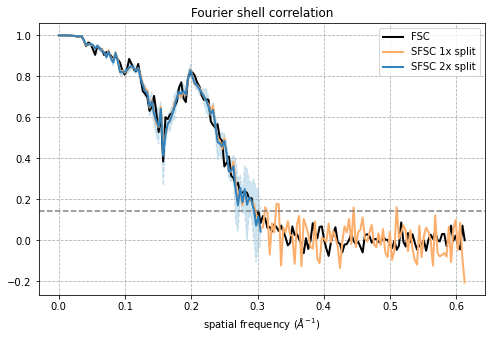

In [6]:
plt.figure(figsize=(8,5))

plt.plot(split_freq, sfsc_2x_adjusted_avg+sfsc_2x_std, color=cmap_b[0], linewidth=1.2, alpha=0.5, linestyle='--')
plt.plot(split_freq, sfsc_2x_adjusted_avg-sfsc_2x_std, color=cmap_b[0], linewidth=1.2, alpha=0.5, linestyle='--')

plt.fill_between(split_freq, sfsc_2x_adjusted_avg+sfsc_2x_std, sfsc_2x_adjusted_avg-sfsc_2x_std,
                 facecolor=cmap_b[0], alpha=0.5, linewidth=0)

plt.plot(freq, fsc_y1y2, color='k', linewidth=2, label='FSC')
plt.plot(freq, sfsc_1x_adjusted, color=cmap_b[1], linewidth=2, label='SFSC 1x split')
plt.plot(split_freq, sfsc_2x_adjusted_avg, color=cmap_a[0], linewidth=2, label='SFSC 2x split')

plt.axhline(1/7, color='gray', linestyle='--')

plt.grid(which='major', linestyle='--')
plt.title('Fourier shell correlation')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.legend()
# plt.savefig('')
plt.show()